### Important - todo, add interaction terms with missingness!

In [195]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [196]:
import fastsparsegams

In [200]:
#Returns X_aug, X_MVI, y
#no intercept because the model has an automatic intercept. 
def data_gen(n=10000, correlation_prop = 0.85, missingness_prop = 0.4, seed = None, n_vars = 3): 
    if n_vars < 2: 
        print('not enough variables!')
        return -1, -1, -1, -1
    
    if seed is not None: 
        np.random.seed(seed)
    
    X = np.random.choice([True, False], (n,n_vars+1))

    #with rate correlation_prop, X_:0 is equal to X_:1
    correlation_indices = np.random.permutation(n)[:int(correlation_prop*n)]
    X[correlation_indices, 0] = X[correlation_indices, 1]
    
    #Y is always X_:0
    y = np.copy(X[:, 0])
        
    #X_:0 is sometimes missing
    missing_indices = np.random.permutation(n)[:int(missingness_prop*n)]
    X[missing_indices, 0] = False
    #last column X_:-1 is missingness indicator for X_:0
    X[:, -1] = False
    X[missing_indices, -1] = True
    
    
    # create median/mode value imputation matrix (which does not include the missingness feature)
    imputed_mode = (X[:, 0]).sum() > (n * (1-missingness_prop))/2 #find majority vote of non-missing values for feature 0
    X_mvi = np.copy(X[:, :-1])
    X_mvi[missing_indices, 0] = imputed_mode
        
    #create augmented matrix (add interaction terms): 
    X_aug = np.concatenate([X, np.logical_and(X[:, -1].reshape(-1, 1), X[:, 1:-1])], axis=1)
    
    return X_aug, X_mvi, y

In [254]:
X_aug_train, X_mvi_train, y_train = data_gen(seed = 2, n_vars=10)

In [255]:
X_aug_test, X_mvi_test, y_test = data_gen(seed = 100, n_vars=10)

In [256]:
model_augmented = fastsparsegams.fit(
    X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
)

In [257]:
trainacc_aug = []
coeff_aug = np.zeros((len(model_augmented.lambda_0[0]), X_aug_train.shape[1]))
testacc_aug = []
for i, lamby in enumerate(model_augmented.lambda_0[0]): 
    acc = ((model_augmented.predict(X_aug_train.astype(float),lambda_0=lamby)>0.5)==y_train.reshape(-1,1)).mean()
    trainacc_aug.append(acc)
    
    coeff_aug[i] = (model_augmented.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    
    acc_test = ((model_augmented.predict(X_aug_test.astype(float),lambda_0=lamby)>0.5)==y_test.reshape(-1,1)).mean()
    testacc_aug.append(acc)

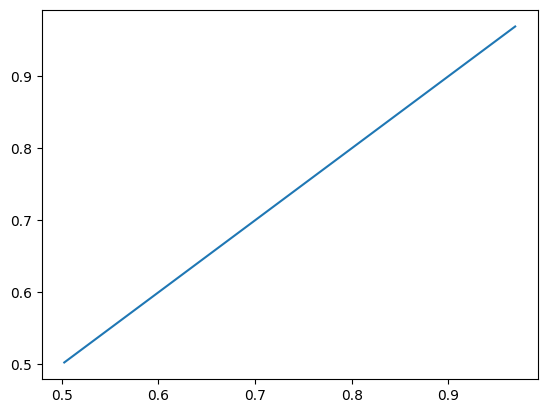

In [258]:
plt.plot(trainacc_aug, testacc_aug)

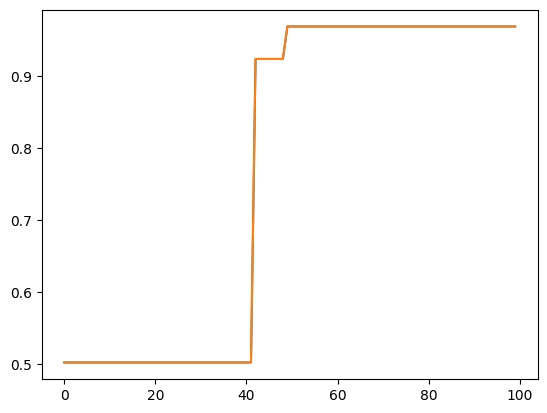

In [259]:
plt.plot(np.arange(100), trainacc_aug)
plt.plot(np.arange(100), testacc_aug)

In [260]:
(coeff_aug > 0).sum(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6])

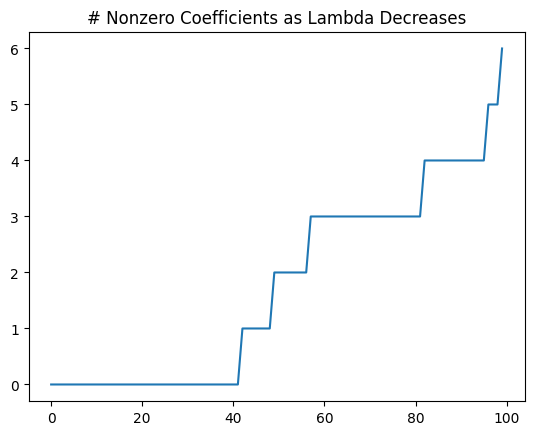

In [261]:
plt.title('# Nonzero Coefficients as Lambda Decreases')
plt.plot(np.arange(100), (coeff_aug > 0).sum(axis=1))

In [265]:
coeff_aug[42]

array([0.        , 2.49836752, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [251]:
testacc_aug[80]

0.9716

### Notes from experiments: 

when the model uses just 1 coefficient, it uses just X_.1, as it should (no missingness, 85% correlation with y)
when it picks 2, it uses X_.0 and then accounts for missingness (use X_.0 as the perfect predictor it is when not missing, then use X_.1's interaction term with X_.0 missingness when X_:0 is missing).
when it picks 3, somehow the training and test accuracy remain unchanged???

coefficients printed are without the intercept term (which is normally the first coefficient)

for mvi (below) the model does the same when using just 1 coefficient, and uses X_.0 and X_.1 when using 2 coefficients, as it has to (those are the only two variables with signal). Grabs noise after that, and does not reach as high an objective

------------------

In [267]:
model_mvimented = fastsparsegams.fit(
    X_mvi_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
)
trainacc_mvi = []
coeff_mvi = np.zeros((len(model_mvimented.lambda_0[0]), X_mvi_train.shape[1]))
testacc_mvi = []
for i, lamby in enumerate(model_mvimented.lambda_0[0]): 
    acc = ((model_mvimented.predict(X_mvi_train.astype(float),lambda_0=lamby)>0.5)==y_train.reshape(-1,1)).mean()
    trainacc_mvi.append(acc)
    
    coeff_mvi[i] = (model_mvimented.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    
    acc_test = ((model_mvimented.predict(X_mvi_test.astype(float),lambda_0=lamby)>0.5)==y_test.reshape(-1,1)).mean()
    testacc_mvi.append(acc)

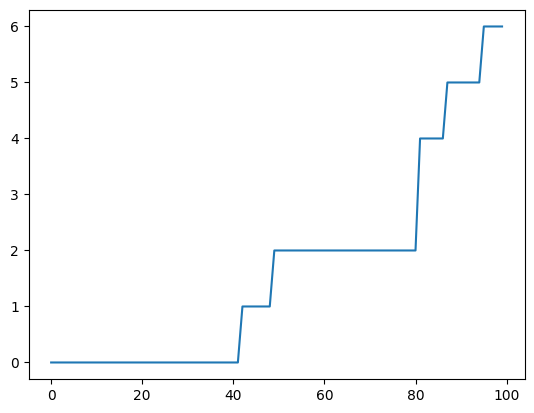

In [268]:
plt.plot(np.arange(100), (coeff_mvi > 0).sum(axis=1))

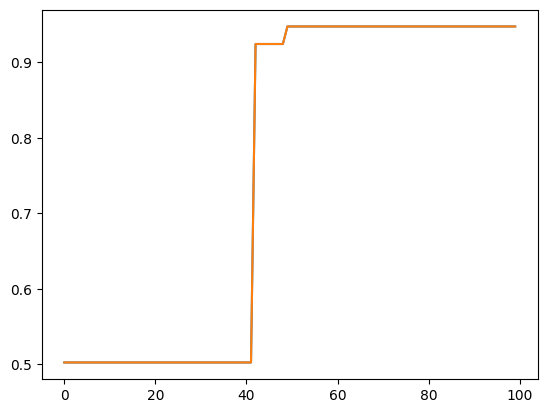

In [271]:
plt.plot(np.arange(100), trainacc_mvi)
plt.plot(np.arange(100), testacc_mvi)

In [277]:
coeff_mvi[60]

array([7.26175948, 2.49727335, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

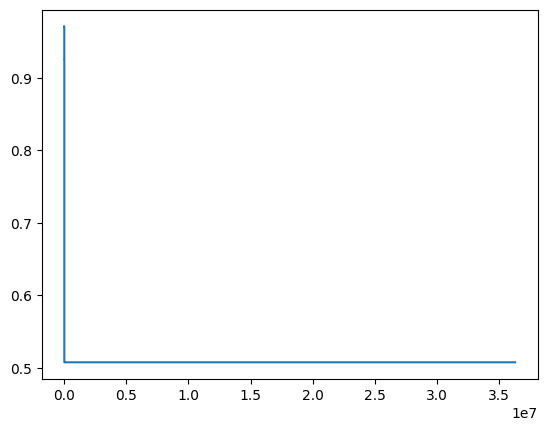

In [214]:
plt.plot(model_augmented.lambda_0[0], testacc_aug)

In [118]:
model_augmented

,l0,support_size,intercept,converged,l2
0,366414.721311,0,-0.024005,True,0.0
1,362750.574098,0,-0.024005,True,0.0
2,290200.459279,0,-0.024005,True,0.0
3,232160.367423,0,-0.024005,True,0.0
4,185728.293938,0,-0.024005,True,0.0
...,...,...,...,...,...
95,0.000609,4,-8.966407,True,0.0
96,0.000487,4,-8.967849,True,0.0
97,0.000390,4,-8.969289,True,0.0
98,0.000312,4,-8.970727,True,0.0


In [20]:
best_model = np.array([[0]
                      [1.0],
                      [0], 
                      [0], 
                      [0], 
                      [1.0], 
                      [0]])